In [1]:
import numpy as np
import torch
import torchvision as tvn
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import sys

In [2]:
nn_params = {'nodes_layer_0': 1024,        
             'nodes_layer_1': 512,  
             'nodes_layer_2': 256,
             'nodes_layer_3': 128
             }

prop_params = {'ReLU_1': 0.2,               
               'ReLU_2': 0.2,
               'ReLU_3': 0.2,
               'ReLU_4': 0.2,
               'Drop_1': 0.25,
               'Drop_2': 0.25,
               'Drop_3': 0.25,
               'Drop_4': 0.25
               }

training_conditions = {'n_epochs': 1,                  
                       'batch_size_train': 64,
                       'batch_size_test': 1000,
                       'learning_rate': 0.01,
                       'momentum': 0.05,
                       'log_interval': 10,
                       'rdm_seed': 1
                       }

In [3]:
torch.manual_seed(training_conditions['rdm_seed'])

In [4]:
train_loader = torch.utils.data.DataLoader(tvn.datasets.MNIST('/files/', train = True, download = True,
                                                            transform = tvn.transforms.Compose([tvn.transforms.ToTensor(),
                                                            tvn.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=training_conditions['batch_size_train'], shuffle=True)

test_loader = torch.utils.data.DataLoader(tvn.datasets.MNIST('/files/', train = False, download = True,
                                                            transform = tvn.transforms.Compose([tvn.transforms.ToTensor(),
                                                            tvn.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=training_conditions['batch_size_test'], shuffle=True)

In [5]:
class NN(torch.nn.Module):
    def __init__(self,nn_params, prop_params):
        super(NN, self).__init__()
        initial_features = 784
        final_features = 10
        self.hidden_layerin = torch.nn.Sequential(torch.nn.Linear(initial_features,nn_params['nodes_layer_0']),torch.nn.LeakyReLU(prop_params['ReLU_1']),torch.nn.Dropout(prop_params['Drop_1']))
        self.hidden_layer1 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_0'],nn_params['nodes_layer_1']),torch.nn.LeakyReLU(prop_params['ReLU_2']),torch.nn.Dropout(prop_params['Drop_2']))
        self.hidden_layer2 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_1'],nn_params['nodes_layer_2']),torch.nn.LeakyReLU(prop_params['ReLU_3']),torch.nn.Dropout(prop_params['Drop_3']))
        self.hidden_layer3 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_2'],nn_params['nodes_layer_3']),torch.nn.LeakyReLU(prop_params['ReLU_4']),torch.nn.Dropout(prop_params['Drop_4']))
        self.layer_out = torch.nn.Linear(nn_params['nodes_layer_3'],final_features)

    def forward(self, x):
        x = x.view(-1,784)
        x_in = self.hidden_layerin(x)
        x_1 = self.hidden_layer1(x_in)
        x_2 = self.hidden_layer2(x_1)
        x_3 = self.hidden_layer3(x_2)
        x_4 = self.layer_out(x_3)
        x_out = torch.nn.functional.log_softmax(x_4,dim=1)
        return [x_out,x_in,x_1,x_2,x_3]

network = NN(nn_params, prop_params)

In [6]:
optimizer = torch.optim.SGD(network.parameters(), lr= training_conditions['learning_rate'],momentum= training_conditions['momentum'])
loss_function = torch.nn.functional.nll_loss

def train(network,train_set,loss_func,method,log_interval,epochs):
    try:
        network.train()
        for index, (data, truth) in enumerate(train_set):
            method.zero_grad()
            output = network(data) 
            loss = loss_func(output[0], truth)
            loss.backward()
            method.step()
            if index % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epochs, index * len(data), len(train_set.dataset),
                                                                    100. * index / len(train_set), loss.item()))
        return [output,truth]
    except:
        print('Error occurred during training. Please check errors: ', sys.exc_info()[2])


def test(network,test_set,loss_func):
    try:
        test_losses = []
        network.eval()
        total_test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for index, (data, truth) in enumerate(test_set):
                output = network(data)
                test_loss = loss_func(output[0], truth, size_average = False)
                total_test_loss += test_loss.item()
                pred = output[0].data.max(1, keepdim = True)[1]
                total_correct += pred.eq(truth.data.view_as(pred)).sum()
        avg_test_loss = total_test_loss / len(test_set.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(avg_test_loss, total_correct, len(test_set.dataset),
            100. * total_correct / len(test_set.dataset)))
        return [output, truth]
    except:
        print('Error occurred during testing. Please check error: ', sys.exc_info()[2])

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(training_conditions['n_epochs'] + 1)]

test(network,test_loader,loss_function)
for epoch in range(1, training_conditions['n_epochs'] + 1): 
    training_data_results = train(network,train_loader,loss_function,optimizer,training_conditions['log_interval'],1)
    testing_data_results = test(network,test_loader,loss_function)

C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3011, Accuracy: 1095/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294295
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301305
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.297035
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.297702
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.290997
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.290269
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292796
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.308970
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.294259
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.270344
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.271259
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.279764
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.281452
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.277405
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.278854
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.269268
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.277972
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.280428
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.268578
Train Epoch: 1 [12160

In [33]:
def layer_visuals(layer_num,data_results,ith):
    chosen_layer = data_results[0][layer_num]
    while True:
        print('The dimensions of the layer: ' + str(chosen_layer.shape))
        base = input('Base: ')
        if base == 'exit':
            break
        height = input('Height: ')
        try:
            fig = plt.figure(figsize=(int(base),int(height)))
            for i in range(ith,ith+10):
                image = chosen_layer[i].view(int(height),int(base))
                for j in range(10):
                    plt.subplot(4,5,j + 1)
                    plt.tight_layout()
                    plt.title(j + ith, fontsize = 25)
                    plt.imshow(image.detach(), cmap = 'gray', interpolation = 'none')
                    plt.xticks([])
                    plt.yticks([])
            plt.show()
            break
        except (RuntimeError):
            print('The proposed dimensions do not match that of the output.\n')
        except (ValueError):
            print('Please use integers only.\n')
        except:
            print('Unexpected Error: ' + sys.exc_info()[2] + '\n')
        

The dimensions of the layer: torch.Size([32, 512])
Base: 32
Height: 16


C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


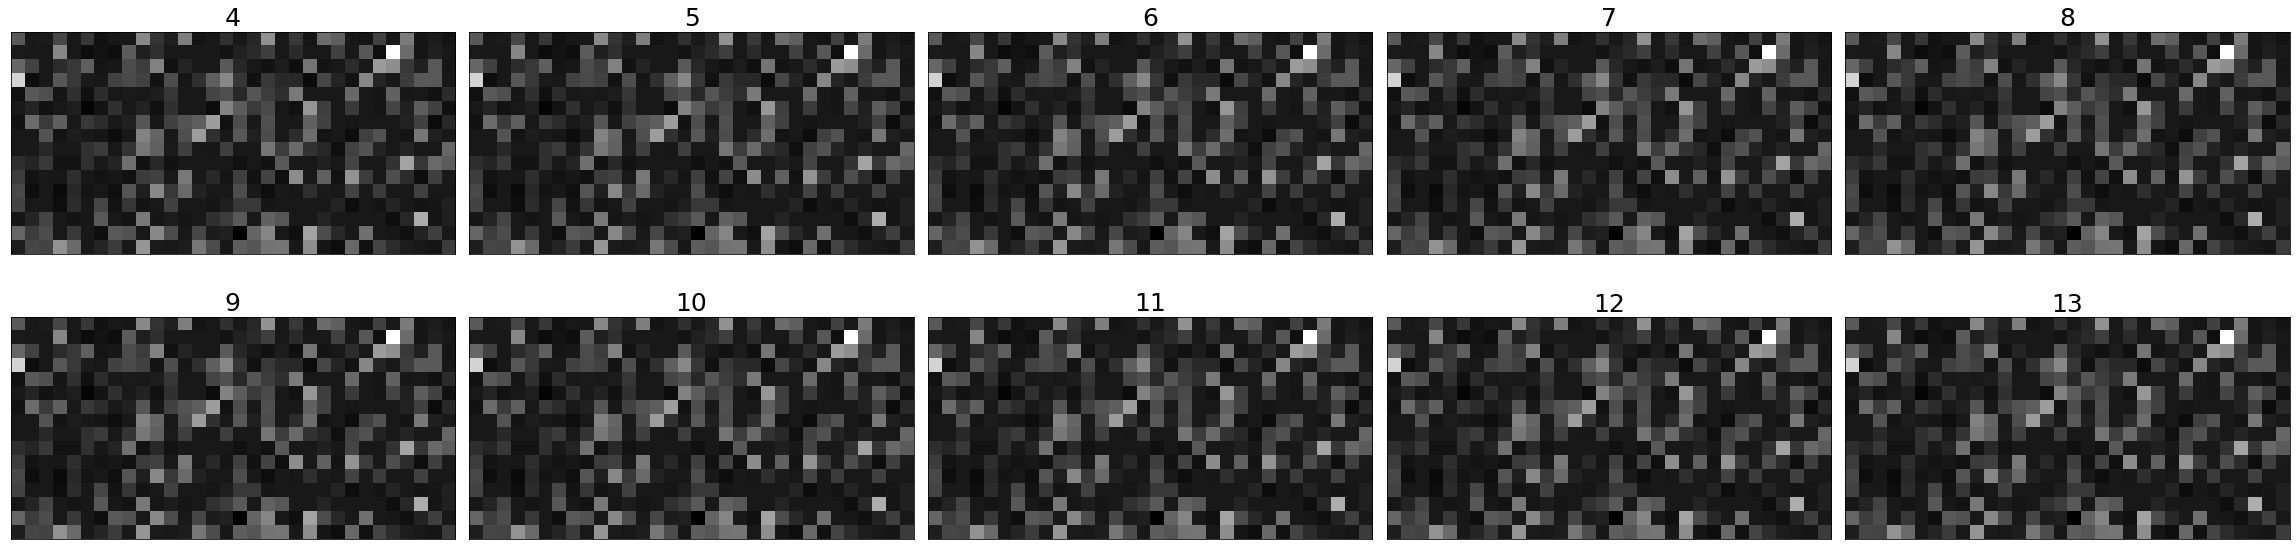

In [34]:
layer_visuals(2,training_data_results,4)

In [10]:
def layer_loss_analysis(layer_num,data_results,loss_func):
    chosen_layer = data_results[0][layer_num]
    print('The dimensions of the layer: ' + str(chosen_layer.shape) +'\n')
    try:
        if len(chosen_layer.shape) == 2:
            layer = torch.nn.functional.log_softmax(chosen_layer, dim=1)
            loss = loss_func(layer, data_results[1])
            print('Layer Number: {}, Loss: {:.6f}\n'.format(layer_num, loss)) 
        else:
            print('Invalid')
    except:
        print('There is a problem with the information you entered: ' + sys.exc_info()[2] + '\n')

In [11]:
layer_loss_analysis(2,training_data_results,loss_function)

The dimensions of the layer: torch.Size([32, 512])

Layer Number: 2, Loss: 6.762490



In [20]:
classes = [0,1,2,3,4,5,6,7,8,9]

def accuracy_individual_classes(network,classes,test_set):
    try:
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))
        for data in test_set:
            images, labels = data
            outputs = network(images)
            _, predicted = torch.max(outputs[0], 1)
            correct = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        for i in range(len(classes)):
            print('Accuracy of %s : %2d%%  [%i/%i]' % (classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    except:
        print('There is an error: ' + sys.exc_info()[2] + '\n' )

In [21]:
accuracy_individual_classes(network,classes,test_loader)

Accuracy of 0 : 96%  [949/980]
Accuracy of 1 : 97%  [1105/1135]
Accuracy of 2 : 78%  [812/1032]
Accuracy of 3 : 84%  [850/1010]
Accuracy of 4 : 85%  [844/982]
Accuracy of 5 : 70%  [631/892]
Accuracy of 6 : 92%  [889/958]
Accuracy of 7 : 88%  [908/1028]
Accuracy of 8 : 79%  [779/974]
Accuracy of 9 : 78%  [788/1009]


In [22]:
def saving_textfile(file,pandas_true,directory):
    try:
        if pandas_true == False:
            f = open(directory,'w+')
            for line in file:
                f.writelines(str(list(line.numpy())))
            f.close()
        else:
            file.to_csv(directory,'w+')
    except:
        print('There is an error: ' + sys.exc_info()[2] + '\n' )

In [73]:
def weights_biases(network):
    parameters = {}
    for i in network.named_parameters():
        parameters[i[0]] = i[1] 
    specific_parameters = parameters.keys()
    try:
        while(True):
            print('The weights and biases of these layers have been identified: \n')
            for j in specific_parameters:
                print(j)
            wanted_parameter = input('Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. \n')
            if wanted_parameter == '0':
                break
            elif wanted_parameter == 'E' or wanted_parameter == 'e':
                wanted_parameter = input('Please enter the parameter to export: \n')
                data = parameters[str(wanted_parameter)].detach()
                saving_textfile(data,False)
                break
            elif wanted_parameter[-4:] == 'bias':
                print('There are %i biases in this layer. \n' % parameters[wanted_parameter].shape)
                while(True):
                    ith_bias_ith_layer, end = input('Enter the bias range. Enter 0 x to exit: \n').split()
                    if end == 'x':
                        break
                    else:
                        print('\n')
                        print(parameters[wanted_parameter][int(ith_bias_ith_layer):int(end)].detach())
                        print('\n')
            else:
                print('\n')
                print('There are %d nodes and %d weights from each node. \n' % (parameters[wanted_parameter].shape[0], parameters[wanted_parameter].shape[1]))
                while(True):
                    ith_node, ith_weight_ith_node = input('Enter the node number and input weights. Enter 0 x to exit: \n').split()
                    if ith_weight_ith_node == 'x':
                        break
                    else:
                        print('\n')
                        print(parameters[wanted_parameter][int(ith_node)][int(ith_weight_ith_node):int(end)].detach())
                        print('\n')
        print('Closed.')
    except:
        print('You entered an invalid input. Please try again.\n')
       

In [74]:
weights_biases(network)

The weights and biases of these layers have been identified: 

hidden_layerin.0.weight
hidden_layerin.0.bias
hidden_layer1.0.weight
hidden_layer1.0.bias
hidden_layer2.0.weight
hidden_layer2.0.bias
hidden_layer3.0.weight
hidden_layer3.0.bias
layer_out.weight
layer_out.bias
Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. 
hidden_layerin.0.weight


There are 1024 nodes and 784 weights from each node. 

Enter the node number and input weights. Enter 0 x to exit: 
0 x
The weights and biases of these layers have been identified: 

hidden_layerin.0.weight
hidden_layerin.0.bias
hidden_layer1.0.weight
hidden_layer1.0.bias
hidden_layer2.0.weight
hidden_layer2.0.bias
hidden_layer3.0.weight
hidden_layer3.0.bias
layer_out.weight
layer_out.bias
Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. 
0
Closed.


In [ ]:
def save_NN(network,method,directory_network,directory_method):
    torch.save(network.state_dict(), directory_network)
    torch.save(method.state_dict(), directory_method)
    
def load_NN(network,method,directory_network,directory_method):
    network.load_state_dict(torch.load(directory_network))
    method.load_state_dict(torch.load(directory_network))
    